# Classificação das imagens utilizando Redes Residuais (ResNet)

## Imports

In [1]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import random
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
from torchvision import datasets, transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

from torchvision import datasets, transforms

## Dataset

O dataset escolhido está disponível no [link](https://www.kaggle.com/datasets/ahmedabdellahismail/covid-19-chest-x-ray/data), o qual é composto de **1196** imagens, pertencentes a três classes:

**COMPLETAR DEPOIS**
*   Covid
*   Virus
*   Normal

In [3]:
# !kaggle datasets download -d ahmedabdellahismail/covid-19-chest-x-ray
# !unzip /content/covid-19-chest-x-ray.zip
# !rm /content/covid-19-chest-x-ray.zip

## Pré-processamento

Carregando o dataset:

In [4]:
# Define a transformação a ser aplicada nas imagens
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensiona a imagem para 128x128
    transforms.ToTensor()          # Converte a imagem para tensor
])

# Carrega o dataset da pasta, assumindo que as subpastas são as classes
dataset = datasets.ImageFolder(root="Data/", transform=transform)

# Defina a proporção de dados de treinamento e teste
train_ratio = 0.8

# Calcula os tamanhos dos conjuntos de treino e teste
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Divide o dataset em conjuntos de treino e teste
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Cria os data loaders para carregar os dados em mini-lotes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

In [5]:
# Conta a quantidade de imagens por classe no conjunto de treinamento
train_class_count = {}
for _, label in train_dataset:
    if label in train_class_count:
        train_class_count[label] += 1
    else:
        train_class_count[label] = 1

# Conta a quantidade de imagens por classe no conjunto de teste
test_class_count = {}
for _, label in test_dataset:
    if label in test_class_count:
        test_class_count[label] += 1
    else:
        test_class_count[label] = 1

# Mostra a quantidade de imagens por classe nos conjuntos de treinamento e teste
print(f'Tamanho do conjunto de treino: {len(train_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de treinamento:")
for class_idx, count in train_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

print(f'\nTamanho do conjunto de teste: {len(test_loader.dataset)}')
print("Quantidade de imagens por classe no conjunto de teste:")
for class_idx, count in test_class_count.items():
    print(f"Classe {class_idx}: {count} imagens")

Tamanho do conjunto de treino: 956
Quantidade de imagens por classe no conjunto de treinamento:
Classe 2: 344 imagens
Classe 1: 377 imagens
Classe 0: 235 imagens

Tamanho do conjunto de teste: 240
Quantidade de imagens por classe no conjunto de teste:
Classe 2: 89 imagens
Classe 1: 91 imagens
Classe 0: 60 imagens


In [6]:
'''# Exibe uma imagem aleatória de cada classe no conjunto de treinamento
print("\nImagens aleatórias de cada classe no conjunto de treinamento:")
class_names = dataset.classes
for class_idx in range(len(class_names)):
    class_name = class_names[class_idx]
    class_files = [file for file, label in dataset.samples if label == class_idx]
    random_files = random.sample(class_files, 4)  # Mostra até 4 imagens por classe
    plt.figure(figsize=(12, 3))
    for i, random_file in enumerate(random_files):
        img = plt.imread(random_file)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Arquivo: {os.path.basename(random_file)}")
        plt.axis('off')
    plt.suptitle(f"Classe {class_name}")
    plt.show()

# Exibe uma imagem aleatória de cada classe no conjunto de teste
print("\nImagens aleatórias de cada classe no conjunto de teste:")
for class_idx in range(len(class_names)):
    class_name = class_names[class_idx]
    class_files = [file for file, label in dataset.samples if label == class_idx][-test_size:]
    random_files = random.sample(class_files, 4)  # Mostra até 4 imagens por classe
    plt.figure(figsize=(12, 3))
    for i, random_file in enumerate(random_files):
        img = plt.imread(random_file)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Arquivo: {os.path.basename(random_file)}")
        plt.axis('off')
    plt.suptitle(f"Classe {class_name}")
    plt.show()'''

'# Exibe uma imagem aleatória de cada classe no conjunto de treinamento\nprint("\nImagens aleatórias de cada classe no conjunto de treinamento:")\nclass_names = dataset.classes\nfor class_idx in range(len(class_names)):\n    class_name = class_names[class_idx]\n    class_files = [file for file, label in dataset.samples if label == class_idx]\n    random_files = random.sample(class_files, 4)  # Mostra até 4 imagens por classe\n    plt.figure(figsize=(12, 3))\n    for i, random_file in enumerate(random_files):\n        img = plt.imread(random_file)\n        plt.subplot(1, 4, i + 1)\n        plt.imshow(img)\n        plt.title(f"Arquivo: {os.path.basename(random_file)}")\n        plt.axis(\'off\')\n    plt.suptitle(f"Classe {class_name}")\n    plt.show()\n\n# Exibe uma imagem aleatória de cada classe no conjunto de teste\nprint("\nImagens aleatórias de cada classe no conjunto de teste:")\nfor class_idx in range(len(class_names)):\n    class_name = class_names[class_idx]\n    class_files = 

##Modelando

In [7]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(test_loader, device)

Residual Block code implementation

In [10]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [11]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [12]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        # self.conv1 = ConvBlock(in_channels, 64)
        # self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        # self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        # self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        # self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        # self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        # self.classifier = nn.Sequential(nn.MaxPool2d(4),
        #                                nn.Flatten(),
        #                                nn.Linear(512, num_diseases))


        self.model = nn.Sequential(
            # Entrada: 1x224x224 (1 canal de cor)
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 32x112x112

            # Entrada: 32x112x112
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 64x56x56

            # Entrada: 64x56x56
            # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # Saída: 128x28x28

            nn.Flatten(),

            nn.Linear(64 * 64 * 64, 512),
            nn.ReLU(),

            nn.Dropout(0.2),

            nn.Linear(512, num_diseases)
        )

    def forward(self, xb): # xb is the loaded batch
        # out = self.conv1(xb)
        # out = self.conv2(out)
        # out = self.res1(out) + out
        # out = self.conv3(out)
        # out = self.conv4(out)
        # out = self.res2(out) + out
        # out = self.classifier(out)
        # return out
        return self.model(xb)

In [13]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=262144, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [14]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
           Flatten-9               [-1, 262144]               0
           Linear-10                  [-1, 512]     134,218,240
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 3]           1,539
Total params: 134,239,363
Trainable par

##Treinando o Modelo

In [15]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()


        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [16]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 488 ms, sys: 130 ms, total: 618 ms
Wall time: 2.32 s


[{'val_loss': tensor(1.1006, device='cuda:0'), 'val_accuracy': tensor(0.2422)}]

In [17]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [18]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00750, train_loss: 15.3631, val_loss: 4.9465, val_acc: 0.5156
Epoch [1], last_lr: 0.00950, train_loss: 3.7314, val_loss: 51.4396, val_acc: 0.5117
Epoch [2], last_lr: 0.00611, train_loss: 1.9692, val_loss: 8.5934, val_acc: 0.6641
Epoch [3], last_lr: 0.00188, train_loss: 0.6553, val_loss: 1.7832, val_acc: 0.7695
Epoch [4], last_lr: 0.00000, train_loss: 0.4019, val_loss: 0.7141, val_acc: 0.9102
CPU times: user 2.49 s, sys: 915 ms, total: 3.41 s
Wall time: 47.7 s


##Resultados

In [19]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

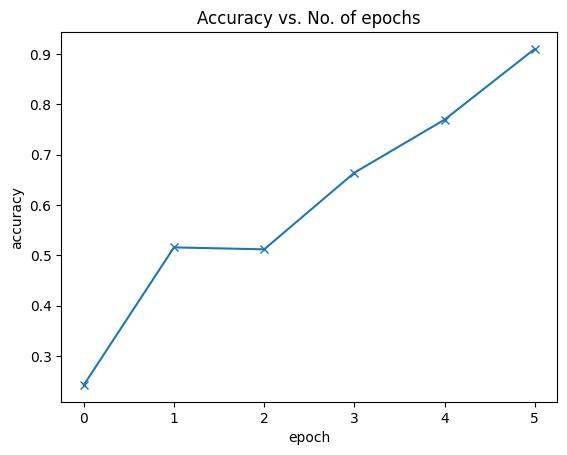

In [20]:
plot_accuracies(history)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

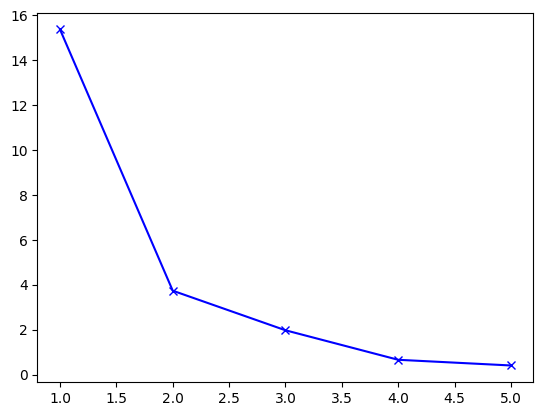

In [21]:
plot_losses(history)

In [ ]:
plot_lrs(history)